## ДЗ №3: Рекуррентные нейронные сети.  Обработка естественного языка

### Пожалуйста, заполните имя

In [1]:
STUDENT_NAME = "Ruslan Sungatullin" # For example, Fedor Petriaikin

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
import progressbar
import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать различные рекуррентные архитектуры для предсказания временного ряда и написания простейшего чат-бота.


### Часть 1. Предсказание временного ряда

а) Напишите свою реализацию LSTM
<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [415]:
# Кстати, на вход в pytorch-реализацию можно подавать последовательности разной длины.
# См. torch.nn.utils.rnn.pack_padded_sequence() и torch.nn.utils.rnn.pack_sequence()
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wi = torch.zeros(input_size, 4*hidden_size, requires_grad=True)
        self.Wh = torch.zeros(hidden_size, 4*hidden_size, requires_grad=True)
        self.b = torch.zeros(4*hidden_size, requires_grad=True)
        self.init_weights()
        
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    # Пропускает через себя последовательность и выдает последний выход
    # X: (seq_len, batch_size, input_size)
    # hidden = (hidden, C): (batch_size, hidden_size)x2 - чтобы начать предсказания с какого-то момента
    # Если None, инициализировать нулями
    # Возвращает out, h, c, где (h, c) - выход и скрытое состояние после последнего элемента
    # out - (seq_len, batch, hidden_size) - выходы каждого слоя
    def forward(self, X, hidden=None):
        batch_size = X.shape[1]
        if hidden is None:
            h, c = torch.zeros(hidden_size, requires_grad=True), torch.zeros(hidden_size, requires_grad=True)
        else:
            h, c = hidden
        out = []
        for x in X:
            gates = x@self.Wi+h@self.Wh+self.b
            f, i, g, o = (torch.sigmoid(gates[:,:self.hidden_size]), 
                          torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size]), 
                          torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size]), 
                          torch.sigmoid(gates[:,3*self.hidden_size:]))
            c = c*f+i*g
            h = o*torch.tanh(c)
            out += [h]
        return out, (h, c)

б) Напишите код обучения LSTM на представленных данных

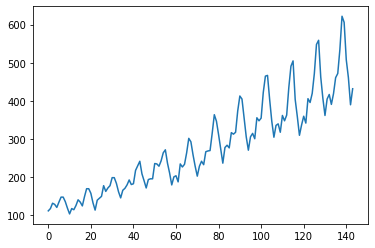

In [406]:
# График (*)
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [407]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [408]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [409]:
# Целевая переменная - сдвинутая последовательность значений входов
# look_back - на сколько смещен test относительно train (seq_len)
# look_forward - сколько нужно предсказать
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [410]:
# Пример подготовленных данных
look_back = 5
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[1], trainX.shape[0], 1))
testX = np.reshape(testX, (testX.shape[1], testX.shape[0], 1))

In [411]:
trainX.shape

(5, 89, 1)

In [512]:
# Берет данные из dataloader, сам их сдвигает, формируя обучающую выборку
# В качестве функции ошибок возьмите MSELoss, оптимизатор - Adagrad
# В функцию можно добавить дополнительные параметры (например, max_epochs, условия останова...)
def TrainModel(model, train_dataloader, test_dataloader, look_back=1, look_forward=1, max_epochs=100):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adagrad(model.parameters())
    losses_train = []
    losses_test = []
    for e in range(max_epochs):
        losses = []
        for train in train_dataloader:
            model.zero_grad()
            X, y = create_dataset(train.numpy(), look_back=look_back, look_forward=look_forward)
            X = np.reshape(X, (X.shape[1], X.shape[0], 1))
            X, y = torch.from_numpy(X), torch.from_numpy(y)
            prediction = model(X)
            loss = loss_fn(y, prediction)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        losses_train.append(np.mean(losses))
        losses = []
        for test in test_dataloader:
            X, y = create_dataset(test.numpy(), look_back=look_back, look_forward=look_forward)
            X = np.reshape(X, (X.shape[1], X.shape[0], 1))
            X, y = torch.from_numpy(X), torch.from_numpy(y)
            prediction = model(X)
            loss = loss_fn(y, prediction)
            losses.append(loss.item())
        losses_test.append(np.mean(losses))
        if e % 10 == 0:
            clear_output(True)
            plt.plot(losses_train, label="train")
            plt.plot(losses_test, label="test")
            plt.legend()
            plt.grid()
            plt.show()

в) Попробуйте обучить сеть с разными параметрами look_back, look_forward. Также попробуйте использовать различные hidden_size. Выведите предсказания на график (\*). Сделайте вывод.  
*Обратите внимание*: "Классический", однонаправленный LSTM имеет размерность выхода (seq_len, batch, hidden_size). Но иногда нужно "изменить" размерность выхода - для этого можно обучить Linear: hidden_size x need_size  

In [523]:
class neural_network(nn.Module):
    def __init__(self, input_size, hidden_size, need_size):
        super(neural_network, self).__init__()
        self.lstm = LSTM(input_size, hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, out_features=need_size)
        
    def forward(self, X):
        o, _ = self.lstm.forward(X)
        o = self.fc(o[-1])
        return o

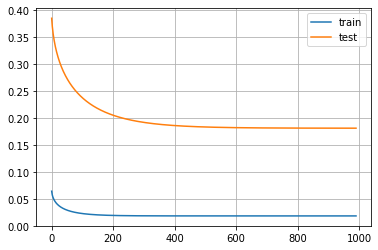

In [515]:
look_back=5
look_forward=1
hidden_size = 100
input_size = 1
batch_size = 128
model = neural_network(input_size, hidden_size, look_forward)
TrainModel(model, DataLoader(train, batch_size, shuffle=False), DataLoader(test, batch_size, shuffle=False), look_back=look_back, look_forward=look_forward, max_epochs=1000)

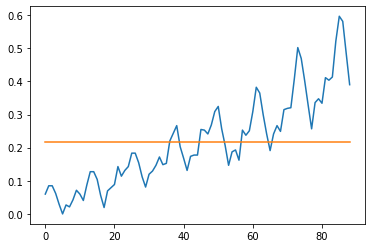

In [516]:
# График (*)
%matplotlib inline
plt.plot(trainY)
y = model.forward(torch.from_numpy(trainX)).detach().numpy()
plt.plot(y)
plt.show()

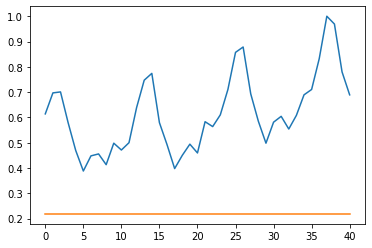

In [517]:
# График (*)
%matplotlib inline
plt.plot(testY)
y = model.forward(torch.from_numpy(testX)).detach().numpy()
plt.plot(y)
plt.show()

Сеть выучилась всегда выдавать среднее на тестовой выборке.

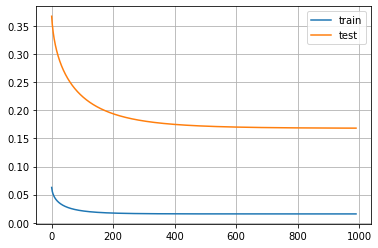

In [519]:
look_back=5
look_forward=7
hidden_size = 256
input_size = 1
batch_size = 128
model = neural_network(input_size, hidden_size, look_forward)
TrainModel(model, DataLoader(train, batch_size, shuffle=False), DataLoader(test, batch_size, shuffle=False), look_back=look_back, look_forward=look_forward, max_epochs=1000)

г) Сравните свой результат и результат с использованием nn.LSTM (на аналогичном числе эпох, hidden_size и т.п.)  

In [524]:
class neural_network_lstm(nn.Module):
    def __init__(self, input_size, hidden_size, need_size):
        super(neural_network_lstm, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.fc = nn.Linear(in_features=hidden_size, out_features=need_size)
        
    def forward(self, X):
        o, _ = self.lstm.forward(X)
        o = self.fc(o[-1])
        return o

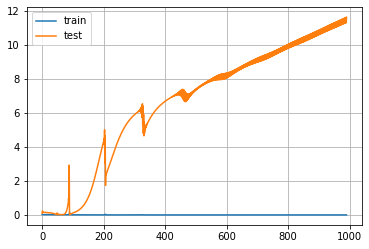

In [525]:
look_back=5
look_forward=1
hidden_size = 128
input_size = 1
batch_size = 128
model = neural_network_lstm(input_size, hidden_size, look_forward)
TrainModel(model, DataLoader(train, batch_size, shuffle=False), DataLoader(test, batch_size, shuffle=False), look_back=look_back, look_forward=look_forward, max_epochs=1000)

Обучимся на 75 эпохах.

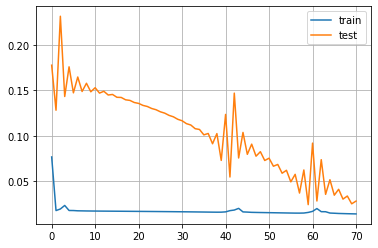

In [528]:
look_back=5
look_forward=1
hidden_size = 128
input_size = 1
batch_size = 128
model = neural_network_lstm(input_size, hidden_size, look_forward)
TrainModel(model, DataLoader(train, batch_size, shuffle=False), DataLoader(test, batch_size, shuffle=False), look_back=look_back, look_forward=look_forward, max_epochs=75)

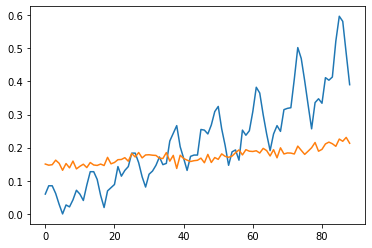

In [530]:
# График (*)
%matplotlib inline
plt.plot(trainY)
y = model.forward(torch.from_numpy(trainX)).detach().numpy()
plt.plot(y)
plt.show()

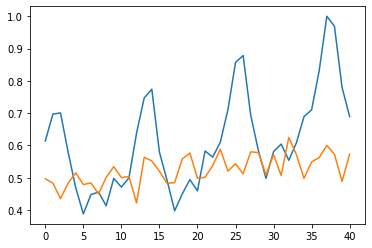

In [531]:
# График (*)
%matplotlib inline
plt.plot(testY)
y = model.forward(torch.from_numpy(testX)).detach().numpy()
plt.plot(y)
plt.show()

д) Попробуйте использовать nn.GRU. Сравните результаты

In [504]:
class neural_network_gru(nn.Module):
    def __init__(self, input_size, hidden_size, need_size):
        super(neural_network_gru, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.fc = nn.Linear(in_features=hidden_size, out_features=need_size)
        
    def forward(self, X):
        o, _ = self.gru.forward(X)
        o = self.fc(o[-1])
        return o

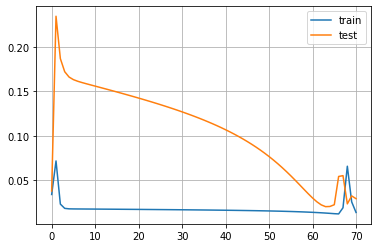

In [534]:
look_back=5
look_forward=1
hidden_size = 128
input_size = 1
batch_size = 128
model = neural_network_gru(input_size, hidden_size, look_forward)
TrainModel(model, DataLoader(train, batch_size, shuffle=False), DataLoader(test, batch_size, shuffle=False), look_back=look_back, look_forward=look_forward, max_epochs=80)

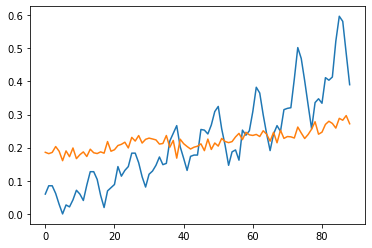

In [536]:
# График (*)
%matplotlib inline
plt.plot(trainY)
y = model.forward(torch.from_numpy(trainX)).detach().numpy()
plt.plot(y)
plt.show()

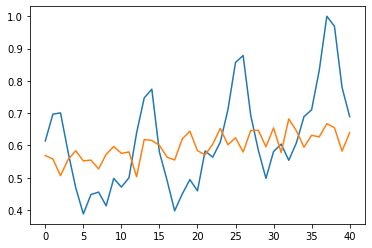

In [537]:
# График (*)
%matplotlib inline
plt.plot(testY)
y = model.forward(torch.from_numpy(testX)).detach().numpy()
plt.plot(y)
plt.show()

От гиперпараметров и модели меняется скорость сходимости и время обучения.

### Часть 2. RNN и обработка текстов

В этом задании мы будем использовать файл author-quote.txt

In [2]:
np.random.seed(777)
torch.random.manual_seed(777)

In [3]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]
lines[0]

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

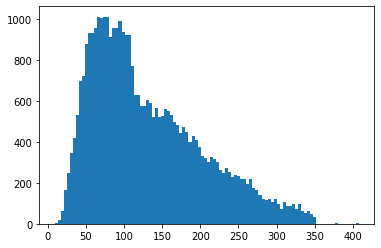

In [4]:
lines_len = []
for l in map(len, lines):
    lines_len.append(l)

plt.hist(lines_len, bins=100);

In [30]:
lines = [l for l in filter(lambda x: len(x) <= 50, lines)]

In [31]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])
    
vocab = Vocabulary(lines)

In [32]:
# <go>, <eos> - специальные токены начала и конца последовательности, нужны для работы предсказаний
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens.tolist())
        _output = np.array(tokens.tolist()+[self.eos])
        return _input, _output

In [33]:
# Для работы pack_padded_sequence
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [43]:
dataset = Quotes(lines, vocab)
dataloader = DataLoader(dataset, shuffle=True, batch_size=4096, collate_fn=compose_batch)

In [44]:
torch.cuda.empty_cache()

In [45]:
torch.cuda.is_available()

True

In [46]:
device = torch.device('cuda:0')

а) Напишите код класса Oracle

In [47]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    # 1) Генерируем эмбединги входных токенов (из _input), пакуем в pack_padded_sequence, используя lengths
    # 2) Запускаем generator на эмбедингах, пакуем его вывод в pad_packed_sequence
    # 3) Возвращаем предикты (пока без SoftMax) через self.classifier
    def forward(self, _input, lengths):
        embeddings = self.embedding(_input)
        pack_padded = nn.utils.rnn.pack_padded_sequence(embeddings, lengths=lengths.T, batch_first=True)
        gen,_ = self.generator(pack_padded)
        pad_packed,_ = nn.utils.rnn.pad_packed_sequence(gen)
        cl = self.classifier(pad_packed)
        return cl

    # Генерирует последовательность (когда уже обучен). Токены переводим в id с помощью vocab.char_to_id,
    # обратно - с помощью vocab.id_to_char
    # Первый токен - <go>, делаем embeding. Далее generator -- classifier -- softmax.
    # Слово сэмплируем с помощью torch.distributions.Categorical, оно становится новым токеном
    # Повторяем, пока не будет <eos> или не достигнем max_len
    # Возвращаем - сгенерированную строку
    def generate(self, vocab, max_len=100):
        line = []
        token = '<go>'
        while len(line) < max_len and token != '<eos>':
            line.append(token)
            x = torch.from_numpy(np.array([vocab.char_to_id[token]])).to(device)
            emb = self.embedding(x)
            emb = emb.view(1, -1, emb.size(1))
            gen, _ = self.generator(emb)
            cl = self.classifier(gen)
            probs = nn.Softmax(dim=2).forward(cl)
            token = torch.distributions.Categorical(probs=probs).sample()
            token = vocab.id_to_char[token.item()]
        line.append('<eos>')
        return ''.join(line) 

б) Обучите модель. Приведите примеры сгенеррованных предложений

In [48]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2).to(device)

In [49]:
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
losses = []
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [50]:
# Чтобы снизить колебания
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

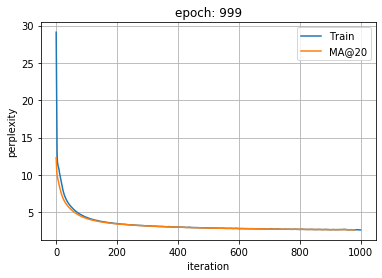


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

In [51]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        go, eos, mask = go.to(device), eos.to(device), mask.to(device)
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.title('epoch: {0}'.format(epoch))
            plt.legend()
            plt.grid()
            plt.show()

In [58]:
oracle.generate(vocab, 100)

"<go>Iven'Antaren''!<eos>"

в) Обучить сеть с LSTM вместо GRU

In [59]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(OracleLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    def forward(self, _input, lengths):
        embeddings = self.embedding(_input)
        pack_padded = nn.utils.rnn.pack_padded_sequence(embeddings, lengths=lengths.T, batch_first=True)
        gen,_ = self.generator(pack_padded)
        pad_packed,_ = nn.utils.rnn.pad_packed_sequence(gen)
        cl = self.classifier(pad_packed)
        return cl
    def generate(self, vocab, max_len=100):
        line = []
        token = '<go>'
        while len(line) < max_len and token != '<eos>':
            line.append(token)
            x = torch.from_numpy(np.array([vocab.char_to_id[token]])).to(device)
            emb = self.embedding(x)
            emb = emb.view(1, -1, emb.size(1))
            gen, _ = self.generator(emb)
            cl = self.classifier(gen)
            probs = nn.Softmax(dim=2).forward(cl)
            token = torch.distributions.Categorical(probs=probs).sample()
            token = vocab.id_to_char[token.item()]
        line.append('<eos>')
        return ''.join(line) 

In [144]:
oracle1 = OracleLSTM(vocab.size, embedding_size=32, hidden_size=64, layers=2).to(device)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
losses = []
optimizer = torch.optim.Adam(oracle1.parameters(), lr=0.01)

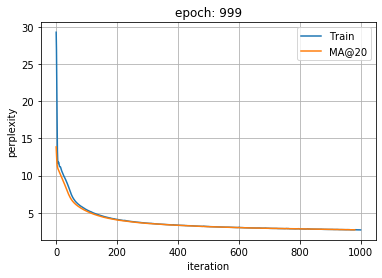



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

In [145]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle1.zero_grad()
        go, eos, mask = go.to(device), eos.to(device), mask.to(device)
        prediction = oracle1(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle1.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.title('epoch: {0}'.format(epoch))
            plt.legend()
            plt.grid()
            plt.show()

In [158]:
oracle1.generate(vocab, 50)

"<go>I femeeee co.fenlnOdokinhaplapyO e'rogiJ feee'? p<eos>"

г) Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох

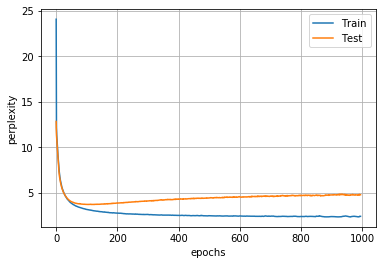



  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.97it/s]

100%|██████████| 3/3 [00:00<00:00, 18.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 29.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.57it/s]

100%|██████████| 3/3 [00:00<00:00, 18.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 28.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.88it/s]

100%|██████████| 3/3 [00:00<00:00, 18.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 29.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.78it/s]

100%|██████████| 3/3 [00:00<00:00, 18.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 22.82it/s]

In [133]:
oracle2 = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2).to(device)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
losses = []
optimizer = torch.optim.Adam(oracle2.parameters(), lr=0.01)
train_lines, test_lines = train_test_split(lines)
train_dataset = Quotes(train_lines, vocab)
test_dataset = Quotes(test_lines, vocab)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1024, collate_fn=compose_batch)
test_dataloader =  DataLoader(test_dataset, shuffle=True, batch_size=1024, collate_fn=compose_batch)
losses_train = []
losses_test = []
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    losses = []
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        oracle2.zero_grad()
        go, eos, mask = go.to(device), eos.to(device), mask.to(device)
        prediction = oracle2(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle2.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
    losses_train.append(np.mean(losses))
    losses = []
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
        go, eos, mask = go.to(device), eos.to(device), mask.to(device)
        prediction = oracle2(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        losses.append(np.exp(loss.item()))
    losses_test.append(np.mean(losses))
    if epoch % 5 == 0:
        clear_output(True)
        plt.plot(losses_train, label='Train')
        plt.plot(losses_test, label='Test')
        plt.xlabel('epochs')
        plt.ylabel('perplexity')
        plt.legend()
        plt.grid()
        plt.show()

После 150 эпох начинается переобучение.

In [143]:
oracle2.generate(vocab)

"<go>Yag6 EVvevevecak; Rpi5 PpinI VvemWrTh8pin'F5n'z$96-wVvet Po3: VvetrcakOl3: VF50!<eos>"

д) Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [233]:
oracle3 = Oracle(vocab.size, embedding_size=64, hidden_size=128, layers=1).to(device)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
losses = []
optimizer = torch.optim.Adam(oracle3.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

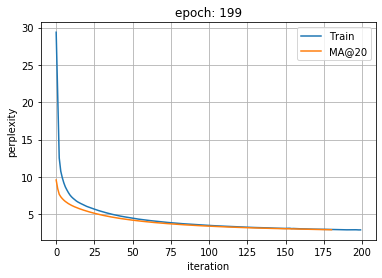






100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

In [234]:
for epoch in range(200):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle3.zero_grad()
        go, eos, mask = go.to(device), eos.to(device), mask.to(device)
        prediction = oracle3(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle3.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.title('epoch: {0}'.format(epoch))
            plt.legend()
            plt.grid()
            plt.show()

In [364]:
oracle3.generate(vocab, 100)

'<go>I athouno p2sheren, Whounf.<eos>'

**Спасибо за выполнение заданий!**